In [ ]:
import sys
import Library.Utility as utility
import Library.AdamWR.adamw as adamw
import Library.AdamWR.cyclic_scheduler as cyclic_scheduler
import PAE as model
import Plotting as plot

import numpy as np
import torch
from torch.nn.parameter import Parameter
import torch.nn.functional as F
import torch.nn as nn
import random

import matplotlib.pyplot as plt

In [1]:
Load = "Dataset"
Save = "Training"

In [9]:
# Start Parameter Section
window = 2.0  # time duration of the time window
fps = 60  # fps of the motion capture data
joints = 75  # 26  # joints of the character skeleton

frames = int(window * fps) + 1
input_channels = 3 * joints  # number of channels along time in the input data (here 3*J as XYZ-component of each joint)
phase_channels = 5  # desired number of latent phase channels (usually between 2-10)

epochs = 3
batch_size = 3200
learning_rate = 1e-4
weight_decay = 1e-4
restart_period = 10
restart_mult = 2

plotting_interval = 500  # update visualization at every n-th batch (visualization only)
pca_sequence_count = 100  # number of motion sequences visualized in the PCA (visualization only)
test_sequence_ratio = 0.01  # ratio of randomly selected test sequences (visualization only)

In [5]:
Data = Load + "/Data.bin"
Shape = utility.LoadTxtAsInt(Load + "/DataShape.txt")
Sequences = utility.LoadSequences(Load + "/Sequences.txt", True, Shape[0])

Loading Dataset/DataShape.txt
Loading Dataset/Sequences.txt


In [10]:
sample_count = Shape[0]
feature_dim = Shape[1]
gather_padding = (int((frames - 1) / 2))
gather_window = np.arange(frames) - gather_padding

### End Parameter Section

In [11]:

def LoadBatches(sequences):
    gather = gather_window.reshape(1, -1).repeat(sequences.shape[0], 0)

    sequences = data_sequences[sequences]

    pivot = sequences[:, 0].reshape(-1, 1)
    min = sequences[:, 1].reshape(-1, 1)
    max = sequences[:, 2].reshape(-1, 1)

    gather = np.clip(gather + pivot, min, max)

    shape = gather.shape

    batch = utility.ReadBatchFromMatrix(Data, gather.flatten())

    batch = batch.reshape(shape[0], shape[1], -1)
    batch = batch.swapaxes(1, 2)
    batch = batch.reshape(shape[0], batch.shape[1] * batch.shape[2])
    return batch

In [15]:
# Start Generate Data Sequences
print("Generating Data Sequences")
data_sequences = []
test_sequences = []

for i in range(Sequences[-1]):
    utility.PrintProgress(i, Sequences[-1])
    indices = np.where(Sequences == (i + 1))[0]
    for j in range(indices.shape[0]):
        slice = [indices[j], indices[0], indices[-1]]
        data_sequences.append(slice)
        if np.random.uniform(0, 1) < test_sequence_ratio and indices[j] >= (indices[0] + gather_padding) and indices[j] <= (indices[-1] - gather_padding):
            test_sequences.append(j)

Generating Data Sequences


## Read data

In [16]:
Data = utility.ReadBinary(Data, sample_count, feature_dim)

Reading binary Dataset/Data.bin... 100 % %


In [17]:
print("Data Sequences:", len(data_sequences))
print("Test Sequences:", len(test_sequences))
data_sequences = np.array(data_sequences)
sample_count = len(data_sequences)
# End Generate Data Sequences

# Initialize all seeds
seed = 23456
rng = np.random.RandomState(seed)
random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.mps.manual_seed(seed)
torch.backends.cudnn.deterministic = True

Data Sequences: 46114
Test Sequences: 441


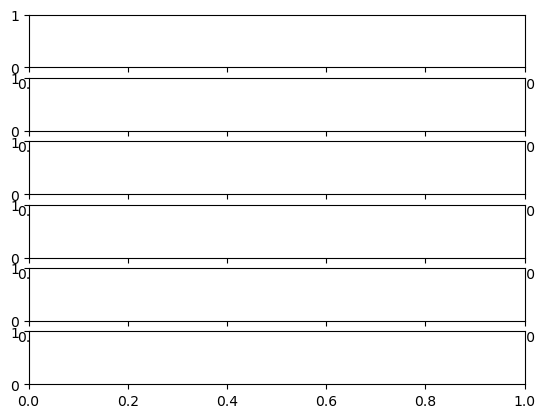

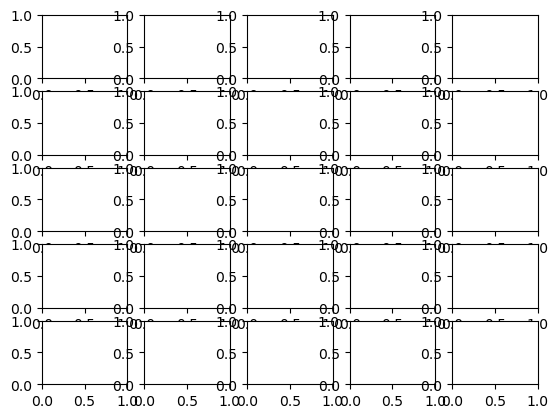

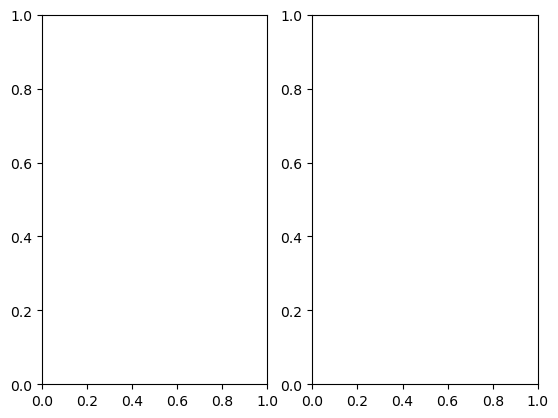

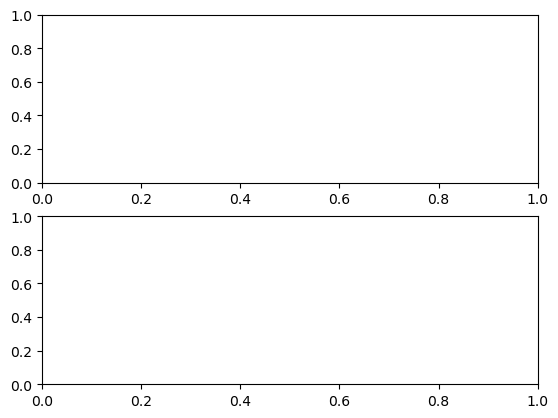

In [18]:
# Initialize drawing
plt.ion()
fig1, ax1 = plt.subplots(6, 1)
fig2, ax2 = plt.subplots(phase_channels, 5)
fig3, ax3 = plt.subplots(1, 2)
fig4, ax4 = plt.subplots(2, 1)
dist_amps = []
dist_freqs = []
loss_history = utility.PlottingWindow("Loss History", ax=ax4, min=0, drawInterval=plotting_interval)

## Build network model

In [19]:
network = utility.ToDevice(model.Model(
    input_channels=input_channels,
    embedding_channels=phase_channels,
    time_range=frames,
    window=window
))

## Setup optimizer and loss function
    

In [21]:
optimizer = adamw.AdamW(network.parameters(), lr=learning_rate, weight_decay=weight_decay)
scheduler = cyclic_scheduler.CyclicLRWithRestarts(optimizer=optimizer, batch_size=batch_size, epoch_size=sample_count, restart_period=restart_period, t_mult=restart_mult, policy="cosine", verbose=True)
loss_function = torch.nn.MSELoss()

In [24]:
I = np.arange(sample_count)

In [25]:
i = 0

train_indices = I[i:i + batch_size]

In [26]:
train_batch = LoadBatches(train_indices)

In [29]:
np.shape(train_batch)

torch.Size([3200, 27225])

In [30]:
train_data = train_batch.reshape(train_batch.shape[0], 225, 121)
np.shape(train_data)

torch.Size([3200, 225, 121])

torch.Size([10, 800])

In [50]:
def visualize_lines(data):
    # Assuming data is of shape (lines, timestamps), where timestamps is the x-axis
    num_lines, num_timestamps = data.shape

    # Create a figure for plotting
    plt.figure(figsize=(10, 6))

    # Plot each line across the timestamps
    for i in range(num_lines):
        plt.plot(range(num_timestamps), data[i], label=f'Line {i + 1}')

    plt.title('Line Visualization over Time')
    plt.xlabel('Timestamps')
    plt.ylabel('Values')
    plt.legend(loc='upper right', bbox_to_anchor=(1.1, 1), ncol=1, fontsize='small')
    plt.show()


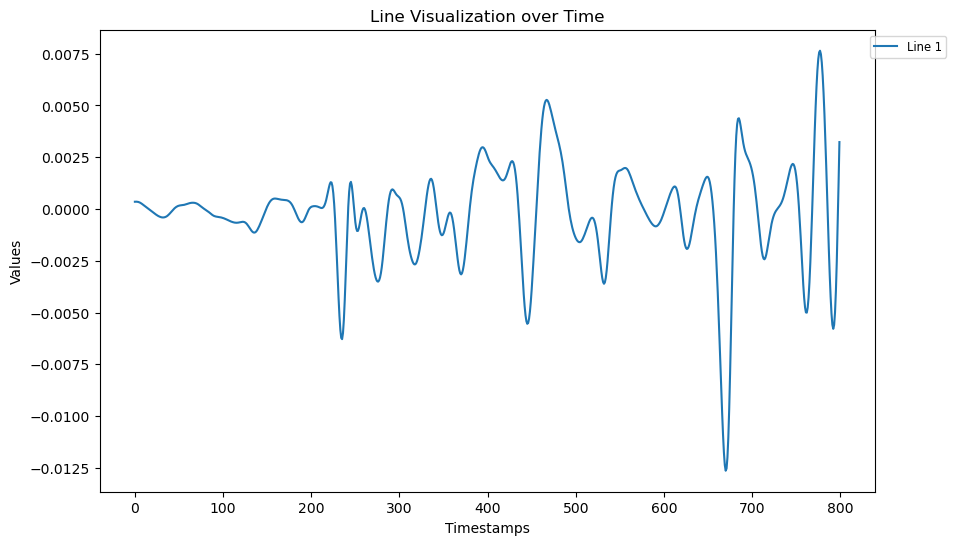

In [54]:
train_data_sample = train_data[200:1000, 1, :1].T
train_data_sample.shape
visualize_lines(train_data_sample.cpu())

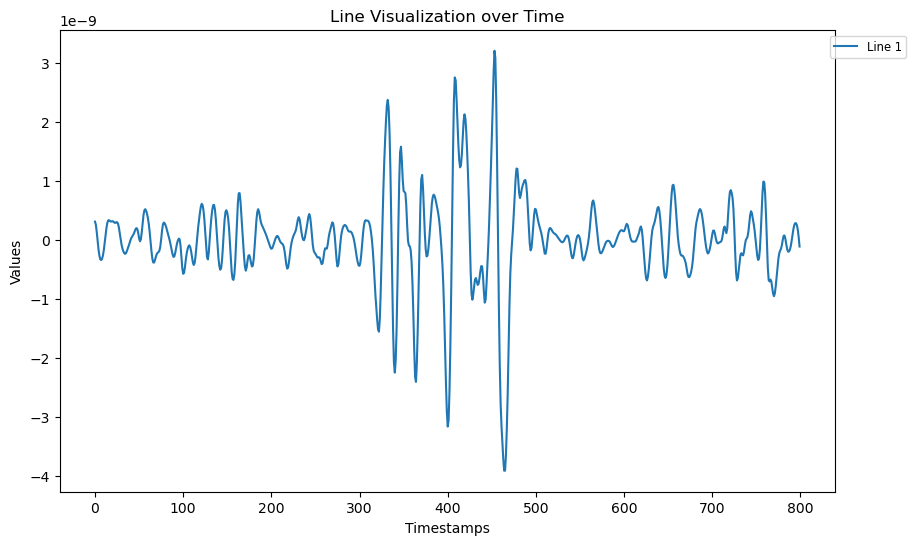

In [58]:
train_data_sample = train_data[200:1000, 0, :1].T
train_data_sample.shape
visualize_lines(train_data_sample.cpu())